# Seasonal Autoregressive Integrated Moving Average (SARIMA) Model

## Introduction
- SARIMA(p,d,q)(P,D,Q)m model, which allows us to model **non-stationary** **seasonal** time series.
- The **seasonal** autoregressive integrated moving average (SARIMA) model, or $SARIMA(p,d,q)(P,D,Q)_m$ expands on $ARIMA(p,d,q)$ model by four new parameters in the model: $P$, $D$, $Q$, and $m$ to take into account **periodic** patterns when forecasting a time series
    - $m$ stands for the frequency which is the number of observations per cycle
        - If the data is every year (1 observation per year), then m=1
        - If data is collected every quarter (4 observations per year), then m = 4.
        - If the data is collected every month, then m = 12. 
        - If the data is collected every week, then m = 52.
        - Note: If the data is collected on a **daily** or **sub-daily** basis, there are multiple ways of interpreting the frequency. (Please refer the "Appropriate frequency m for daily and sub-daily data" for more details)
            - It could be the frequency m = 7 as there would be seven observations in a full cycle of 1 week. 
            - It could be the frequency m = 5 if the data is only collected on weekend day.
            - It could also have a yearly seasonality, meaning that m = 365.
    - $P$ is the order of the **seasonal AR(P)** process
    - $D$ is the **seasonal order** of integration: a seasonal difference makes the series stationary
    - $Q$ is the order of the **seasonal MA(Q)** process
- Example: For the monthly data, which means that $m=12$
    - If $P=2$, the SARIMA model includes the two past values of the series at *a lag that is a mulitple of* $m$, which are $y_{t-1*12}$ and $y_{t-2*12}$ 
    - If $D=1$, this means that a seasonal difference makes the series stationary
    $$y_t'=y_t - y_{t-12}$$
    - If $Q=2$, the SARIMA model includes past error terms at lags that are *a multiple of* $m$, which are $\epsilon_{t–1*12}$ and $\epsilon_{t–2*12}$

<p align="center"><img src="../../assets/img/sarima-determine-m-for-daily-sub-daily-data.png" width=700><br>Appropriate frequency m for daily and sub-daily data</p>

- **Time series decomposition** can be used to identify seasonal patterns in a time series.

In [1]:
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

from itertools import product
from tqdm import tqdm
from typing import Union, Tuple
import warnings

np.random.seed(42)  
warnings.filterwarnings('ignore')

## Identifying seasonal patterns in a time series
- Time series decomposition is a statistical task that separates the time series into its three main components: 
    - **Trend** component: long-term change (increase & decrease) in the time series
    - **Seasonal** component: repeated fluctuations that occur over a fixed period of time. 
    - **Residuals**:  the noise, express any irregularity that cannot be explained by the trend or the seasonal component.

In [2]:
df = pd.read_csv("../../data/book-time-series-forecasting-in-python/air-passengers.csv")
df.head()


,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
df.Month.min(), df.Month.max()

('1949-01', '1960-12')

In [4]:
fig = px.line(df, x='Month', y='Passengers')
for year in range(1949, 1962):
    fig.add_vline(f"{year}-01", line=dict(dash='dot'))

fig.update_layout(
    yaxis_title='Number of Air Passengers',
    xaxis_title='Month',
    title="Airline’s Total Monthly Air assengers"
)  

- From the plot, there is a repeating pattern every year, with 
    - A high number of passengers being recorded during June, July, and August of each year
    - Fewer passengers in November, December, and January of each year.

- Decompose the series using the `STL` function of `statsmodels` to determine if our data is seasonal or not. 
- The period is equal to the frequency $m$. 
    - Since we have monthly data, the period is 12.

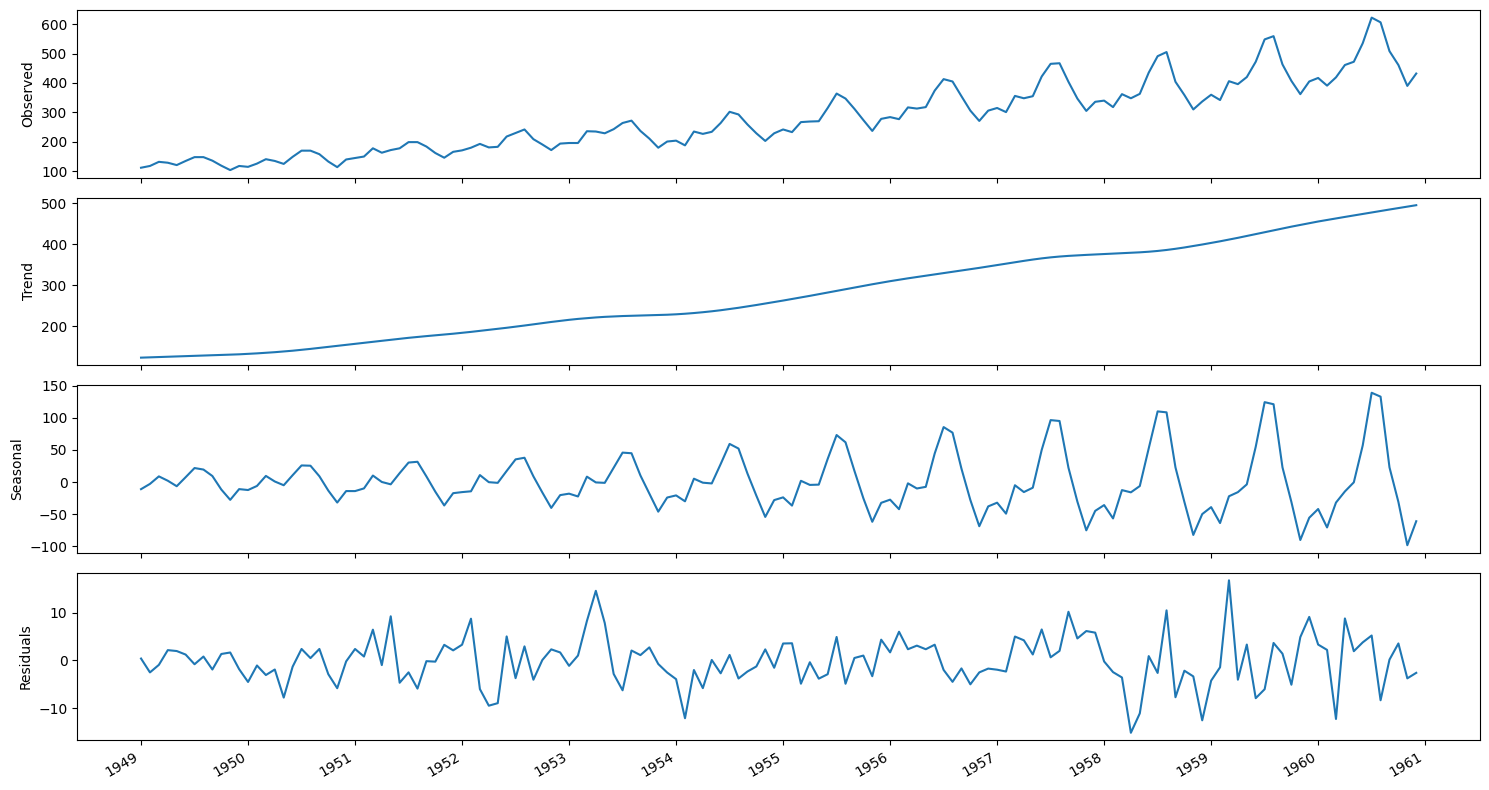

In [5]:
# Decompose the series using the STL function. 
# The period is equal to the frequency m. Since we have monthly data, the period is 12.
def decompose_ts(df, period=12):
    decomposition = STL(df, period=period).fit()

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(15,8))

    ax1.plot(decomposition.observed)
    ax1.set_ylabel('Observed')

    ax2.plot(decomposition.trend)
    ax2.set_ylabel('Trend')

    ax3.plot(decomposition.seasonal)
    ax3.set_ylabel('Seasonal')

    ax4.plot(decomposition.resid)
    ax4.set_ylabel('Residuals')

    fig.autofmt_xdate()
    plt.tight_layout()

decompose_ts(df['Passengers'])

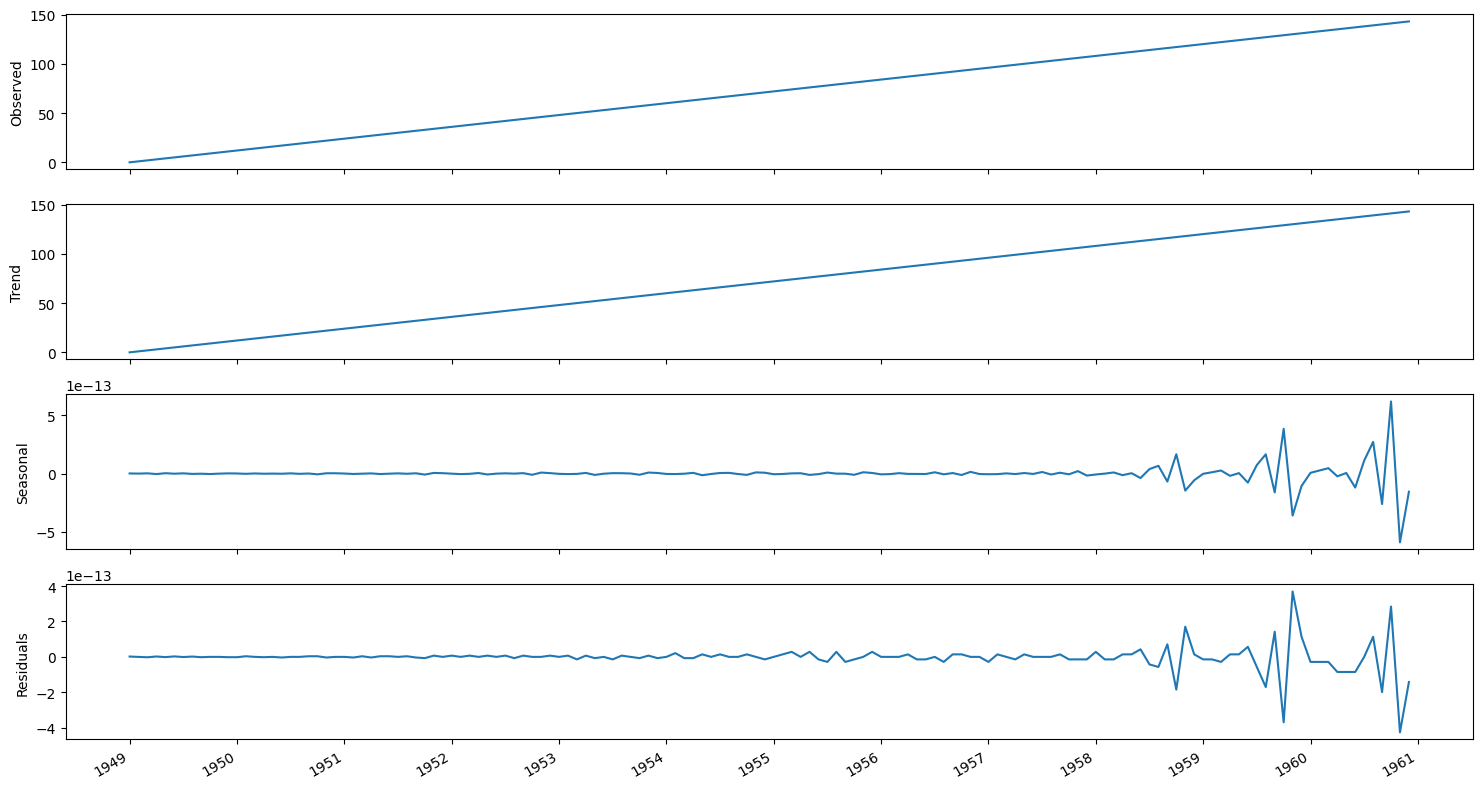

In [6]:
# example of non-seasonal time-series
decompose_ts(np.arange(0, 144, 1))

## Forecasting with SARIMA
- Check  for stationarity and apply transformation in order to set the parameter $d$

In [7]:
def check_stationarity(series, p_significant=0.05):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    adfuller_result = adfuller(series)
    kpss_result = kpss(series)

    print(f'ADF Statistic : {adfuller_result[0]:.5f}, p-value: {adfuller_result[1]:.5f}')
    print('Critical Values:')
    for key, value in adfuller_result[4].items():
        print('\t%s: %.3f' % (key, value))
    print(f'KPSS Statistic: {kpss_result[0]:.5f}, p-value: {kpss_result[1]:.5f}')
    if (adfuller_result[1] <= p_significant) & (adfuller_result[4]['5%'] > adfuller_result[0]) & (kpss_result[1] > p_significant):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [8]:
check_stationarity(df["Passengers"])

ADF Statistic : 0.81537, p-value: 0.99188
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
KPSS Statistic: 1.65131, p-value: 0.01000
Non-stationary


In [9]:
# The time series is not stationary.
# Apply a transformation to our data in order to make it stationary. Let’s apply a first-order differencing using numpy.
df_diff = np.diff(df["Passengers"], n=1)
check_stationarity(df_diff)

ADF Statistic : -2.82927, p-value: 0.05421
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
KPSS Statistic: 0.02390, p-value: 0.10000
Non-stationary


In [10]:
df_diff_seasonal_diff = np.diff(df_diff, n=12)
check_stationarity(df_diff_seasonal_diff)

ADF Statistic : -17.62486, p-value: 0.00000
Critical Values:
	1%: -3.488
	5%: -2.887
	10%: -2.580
KPSS Statistic: 0.06576, p-value: 0.10000
Stationary


- Since the series is still not stationary. Let's try the seasonal differencing on top of first differencing $d=1$
- Seasonal differencing: 
    - since we have monthly data, m = 12, so the seasonal difference is the difference between two values that are 12 timesteps apart.

- Since the series also stationary after 1 rounds of seasonal differencing, so we set $d=1$ and $D=1$

In [11]:
# train-test split
# test set: using the last 12 months of the data as the test set 
train = df['Passengers'][:-12]
test = df.iloc[-12:]      

# baseline model: naive seasonal forecast, where we simply use the number of air passengers for each month of 1959 as a forecast for each month of 1960.
test['naive_seasonal'] = df['Passengers'].iloc[120:132].values  

- The implementation of SARIMA in statsmodels simply uses $s$ instead of $m$ — they both denote the frequency.

In [12]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm(order_list):
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

- Case 1 - using ARIMA: Define a range of possible values for the parameters $p$ and $q$ and fit all unique $ARIMA(p,d,q)$ models
    - Since the series is seasonal, we can hypothesize that the number of air passengers in January of a given year is likely predictive of the number of air passengers in January of the following year.
    - Since these two points are 12 timesteps apart, we’ll allow the values of p and q to vary **from 0 to 12** in order to potentially capture this seasonal information in the ARIMA(p,d,q) model


- As the first order differencing is not stationary & since we use ARIMA, so the series was differenced twice to become stationary, $d = 2$.

In [13]:
df_diff2 = np.diff(df_diff, n=1)
check_stationarity(df_diff2)

ADF Statistic : -16.38423, p-value: 0.00000
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
KPSS Statistic: 0.13467, p-value: 0.10000
Stationary


In [14]:
# Case 1: modeling with ARIMA model, which means P & Q is set to 0 
ps = range(0, 13, 1) # The order p can have the values {0 to 12} 
qs = range(0, 13, 1) # The order q can have the values {0 to 12} 
Ps = [0] # if P=0, Q=0, so the model is equivalent to ARIMA
Qs = [0]

d = 2
D = 0
s = 12 # in SARIMA, "m" is represented as "s"

ARIMA_order_list = list(product(ps, qs, Ps, Qs))
ARIMA_result_df = optimize_SARIMA(train, ARIMA_order_list, d, D, s)

100%|██████████| 169/169 [01:15<00:00,  2.24it/s]


In [15]:
ARIMA_result_df.head()

,"(p,q,P,Q)",AIC
0,"(11, 3, 0, 0)",1016.844019
1,"(11, 4, 0, 0)",1019.018661
2,"(11, 5, 0, 0)",1020.379397
3,"(12, 0, 0, 0)",1020.896655
4,"(11, 1, 0, 0)",1021.024227


- The model with the lowest AIC is a $SARIMA(11,2,3)(0,0,0)_{12}$ model, which is equivalent to an $ARIMA(11,2,3)$ model.
    - Allowing the order $p$ to vary from 0 to 12 was beneficial for the model, as the model with the lowest AIC takes into account the past 11 values of the series

- Next step: to perform Residual Analysis on the best model 
    - Based on the qualitative analysis (Q-Q), the residuals are close to the normal distribution, meaning that the errors are random.
    - Base on the quatitative analysis (Ljung-Box) test, there are some correlation at lags 1 and 2. 
        - This means that our ARIMA model is not capturing all the information from the data.

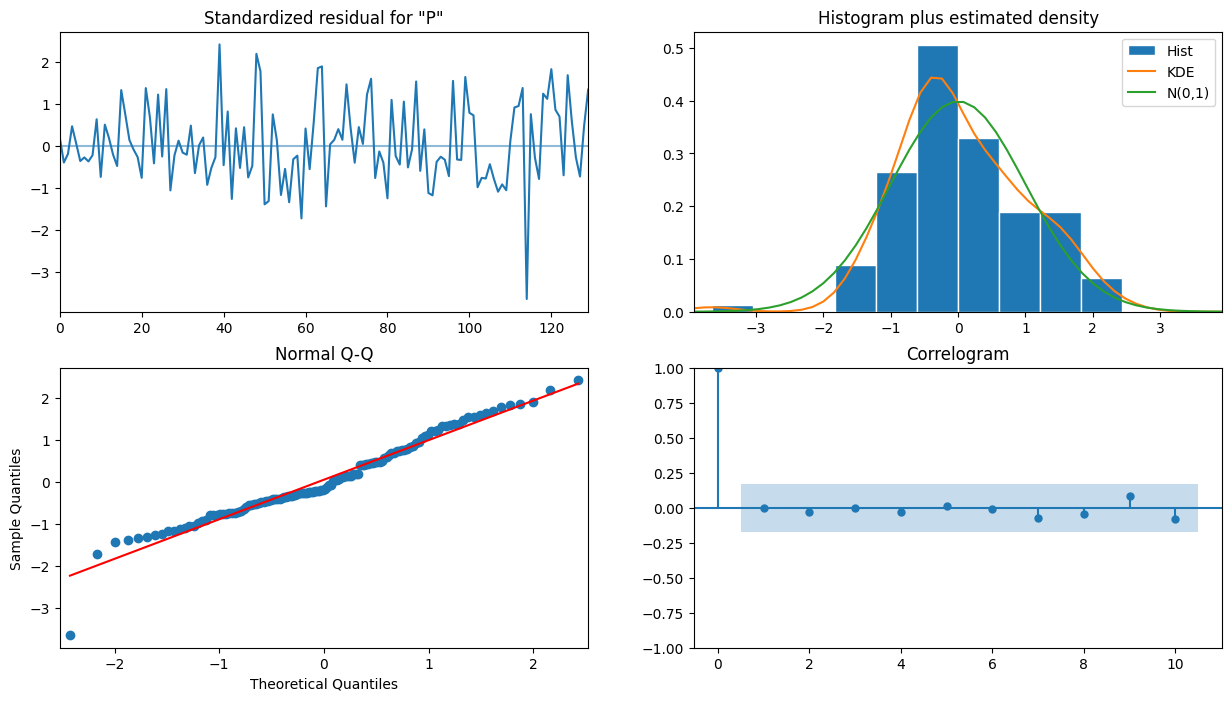

In [16]:
# Residual Analysis
ARIMA_model = SARIMAX(train, order=(11,2,3), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)
 
ARIMA_model_fit.plot_diagnostics(figsize=(15,8));

In [17]:
residuals = ARIMA_model_fit.resid
jb_df = acorr_ljungbox(residuals, np.arange(1, 11, 1))
(jb_df["lb_pvalue"] >= 0.05).sum() == 10 # this to ensure all the lags, the p-value exceed 0.05, so we cannot reject the null hypo

False

In [18]:
jb_df.head()

,lb_stat,lb_pvalue
1,6.548847,0.010495
2,6.675053,0.035525
3,6.949376,0.073529
4,7.745133,0.101373
5,8.389467,0.136037


- The Ljung-Box test points to some correlation at lags 1 and 2. This means that our ARIMA model is not capturing all the information from the data.

In [19]:
# However, we will also get the prediction on the ARIMA model to compare with SARIMA model later on.
ARIMA_pred = ARIMA_model_fit.get_prediction(132, 143).predicted_mean # test set: index from 132 to 143
 
test['ARIMA_pred'] = ARIMA_pred                                         

- Case 2- using SARIMA

In [20]:
# Case 2: modeling with SARIMA
ps = range(0, 4, 1)                                                     
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)
 
SARIMA_order_list = list(product(ps, qs, Ps, Qs))                                                            
 
d = 1 # try with d=2, but it didnt yield a good model (from the residual analysis)
D = 1
s = 12
 
SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)   


100%|██████████| 256/256 [08:37<00:00,  2.02s/it]


In [21]:
SARIMA_result_df.head()

,"(p,q,P,Q)",AIC
0,"(2, 1, 1, 2)",892.247470
1,"(2, 1, 2, 1)",893.603770
2,"(2, 1, 1, 3)",894.106734
3,"(1, 0, 1, 2)",894.285378
4,"(0, 1, 1, 2)",894.992585


- the $SARIMA(2,1,1)(1,1,2)_{12}$ model has the lowest AIC, which is a value of 892.16.

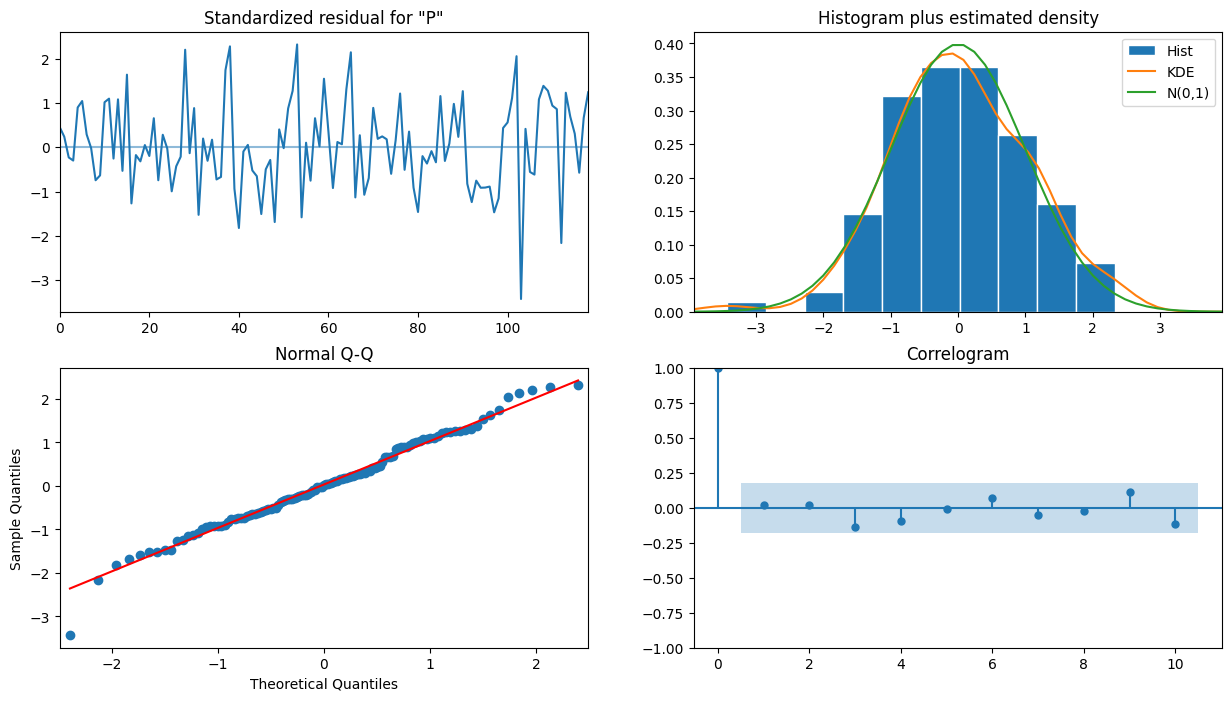

In [22]:
# perform residual analysis on SARIMA(2,2,2)(1,1,2)_{12}
SARIMA_model = SARIMAX(train, 
                       order=(2,1,1), # p,d,q
                       seasonal_order=(1,1,2,12), # P, D, Q, S (or M)
                       simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)
 
SARIMA_model_fit.plot_diagnostics(figsize=(15,8));

- The results shows that the residuals’ distribution is very close to a normal distribution. 

In [23]:
residuals = SARIMA_model_fit.resid
jb_df = acorr_ljungbox(residuals, np.arange(1, 11, 1))
(jb_df["lb_pvalue"] >= 0.05).sum() == 10 # this to ensure all the lags, the p-value exceed 0.05, so we cannot reject the null hypo

True

In [32]:
SARIMA_pred = SARIMA_model_fit.get_prediction(132, 143)
test['SARIMA_pred'] = SARIMA_pred.predicted_mean
SARIMA_pred.conf_int().head() # get the confidence level 

,lower Passengers,upper Passengers
132,400.564773,436.524718
133,377.328670,421.900534
134,435.525529,487.200823
135,421.714881,481.268432
136,441.466585,506.164192


In [33]:
def rolling_forecast(df: pd.DataFrame, 
                     train_len: int, 
                     horizon: int, 
                     window: int, 
                     order: Tuple[int, int, int],
                     seasonal_order: Tuple[int, int, int, int]) -> list:
    total_len = train_len + horizon
    pred, upper_ci, lower_ci = [], [], []
        
    for i in range(train_len, total_len, window):
        model = SARIMAX(df[:i], 
                        order=order, 
                        seasonal_order=seasonal_order,
                        simple_differencing=False
        )
        res = model.fit(disp=False)
        predictions = res.get_prediction(0, i + window - 1)  # get prediction from timestep 0 to 80+2-1 (if window=2)
        oos_pred = predictions.predicted_mean.iloc[-window:] # get only the prediction  [-2:]
        ci = predictions.conf_int().iloc[-window:] # to get the confidence levels [lower, upper]
        pred.extend(oos_pred)
        lower_ci.extend(ci.iloc[:, 0]) # lower confidence interval
        upper_ci.extend(ci.iloc[:, 1]) # upper confidence interval
        
    return pred, lower_ci, upper_ci

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1 # 1 steps at the time for the prediction
SARIMA_pred_rolling, SARIMA_lower_ci_rolling, SARIMA_upper_ci_rolling = rolling_forecast(df['Passengers'], TRAIN_LEN, HORIZON, WINDOW,(2,1,1), (1,1,2,12))
test['SARIMA_pred_rolling'] = SARIMA_pred_rolling
test['SARIMA_lower_ci_rolling']= SARIMA_lower_ci_rolling
test['SARIMA_upper_ci_rolling']=SARIMA_upper_ci_rolling

In [26]:
methods = ["naive_seasonal", "ARIMA_pred","SARIMA_pred", "SARIMA_pred_rolling"]

In [45]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df[-15:].Month, y=df[-15:]['Passengers'], name='actual', line = dict(color='royalblue')))

for pred_type in methods: 
    fig.add_trace(go.Scatter(x=test.Month, y=test[pred_type], name=pred_type, line = dict(dash='dash')))
fig.add_trace(go.Scatter(x=test.Month, y=test["SARIMA_lower_ci_rolling"],
    fill=None,
    mode='lines',
    showlegend = False,
    line_color='rgba(0,0,0,0)',
    ))
fig.add_trace(go.Scatter(x=test.Month, y=test["SARIMA_upper_ci_rolling"],
    fill='tonexty', # fill area between trace0 and trace1
    name="Confidence Interval - SARIMA_pred_rolling",
    mode='lines', line_color='rgba(0,0,0,0)', fillcolor = 'rgba(255, 0, 0, 0.2)'))


fig.update_layout(
    yaxis_title='Month',
    xaxis_title='Number of air passenggers',
    title='Prediction on Test Set'
)  
fig.show()

In [41]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape_naive_seasonal = mape(test['Passengers'], test['naive_seasonal'])
mape_ARIMA = mape(test['Passengers'], test['ARIMA_pred'])
mape_SARIMA = mape(test['Passengers'], test['SARIMA_pred'])
mape_SARIMA_rolling = mape(test['Passengers'], test['SARIMA_pred_rolling'])

print(mape_naive_seasonal, mape_ARIMA, mape_SARIMA, mape_SARIMA_rolling)

9.987532920823485 3.8413887130452378 2.8581143231377797 3.093198158963915


- The baseline achieves a MAPE of 9.98%. 
- The ARIMA model produced forecasts with a MAPE of 3.84%
- The SARIMA model scored a MAPE of 2.85%. (champion)
- A MAPE closer to 0 is indicative of better predictions, so the SARIMA model is the best-performing method for this situation